<a href="https://colab.research.google.com/github/YI-CHENG-SHIH645/ML/blob/master/DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Imports
!wget "https://github.com/YI-CHENG-SHIH645/ML-in-Business_practice/raw/main/utils.py"
!pip install scikit-learn==0.24.1

from utils import DataLoader, classifier_measurement_under_threshs
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from scipy.stats import norm
from sklearn import set_config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import itertools
import seaborn as sns
from math import sqrt
from matplotlib import style

set_config(display='diagram')

--2021-04-02 13:07:05--  https://github.com/YI-CHENG-SHIH645/ML-in-Business_practice/raw/main/utils.py
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/YI-CHENG-SHIH645/ML-in-Business_practice/main/utils.py [following]
--2021-04-02 13:07:05--  https://raw.githubusercontent.com/YI-CHENG-SHIH645/ML-in-Business_practice/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7290 (7.1K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   7.12K  --.-KB/s    in 0s      

2021-04-02 13:07:05 (30.2 MB/s) - ‘utils.py’ saved [7290/7290]

     |███████████████████████

In [ ]:
lending_club_train_df = DataLoader.load_data('lending_club_reduced_train_url')
lending_club_test_df = DataLoader.load_data('lending_club_reduced_test_url')

# Information Theory

$-ln(p(x))$ <br>

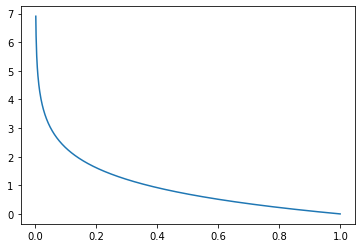

In [ ]:
#@markdown 越不可能發生，output值越大 <br>
#@markdown 越可能發生，output值越小 <br>
p_x = np.linspace(1e-3, 1-1e-3, 1000)
plt.plot(p_x, -np.log(p_x))
plt.show()

In [ ]:
err_perfect = [.0, .0, .0]
err = [2, 3, 5]
err_improved = [1, 2, 4]
gau = norm(0., 1.)
print(-np.log(gau.pdf(err_perfect)))
print(-np.log(1/np.sqrt(2*np.pi)))
print(-np.log(gau.pdf(err)))
print(-np.log(gau.pdf(err_improved)))

[0.91893853 0.91893853 0.91893853]
0.9189385332046727
[ 2.91893853  5.41893853 13.41893853]
[1.41893853 2.91893853 8.91893853]


entropy = $-\sum_{i} p(x_i)ln(p(x_i))$ <br>

(1%) 0.06643856189774724
更不可能發生(0.1%)： 0.009965784284662087 

99%: 0.01435457399816394
更可能發生(99.9%): 0.00144197345279905 



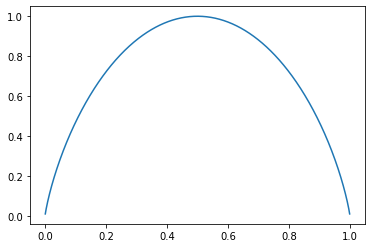

In [ ]:
#@markdown pdf 隨機性(不可預測性)越大，值越高 <br>
#@markdown 越不可能發生的事，產生的值應該越小 <br>
#@markdown 越可能發生的事，產生的值應該越小
print("(1%)", 1e-2 * -np.log2(1e-2))
print("更不可能發生(0.1%)：", 1e-3 * -np.log2(1e-3), '\n')
print("99%:", 9.9e-1 * -np.log2(9.9e-1))
print("更可能發生(99.9%):", 9.99e-1 * -np.log2(9.99e-1), '\n')
plt.plot(p_x, p_x * -np.log2(p_x) + (1-p_x) * -np.log2(1-p_x))
plt.show()

#@markdown 事實：uniform distribution 使得 entropy 最大

# Decision Tree Construction
* classification
    * maximize information gain(initial entropy - expected entropy) on each split

label 比例: 0.828 



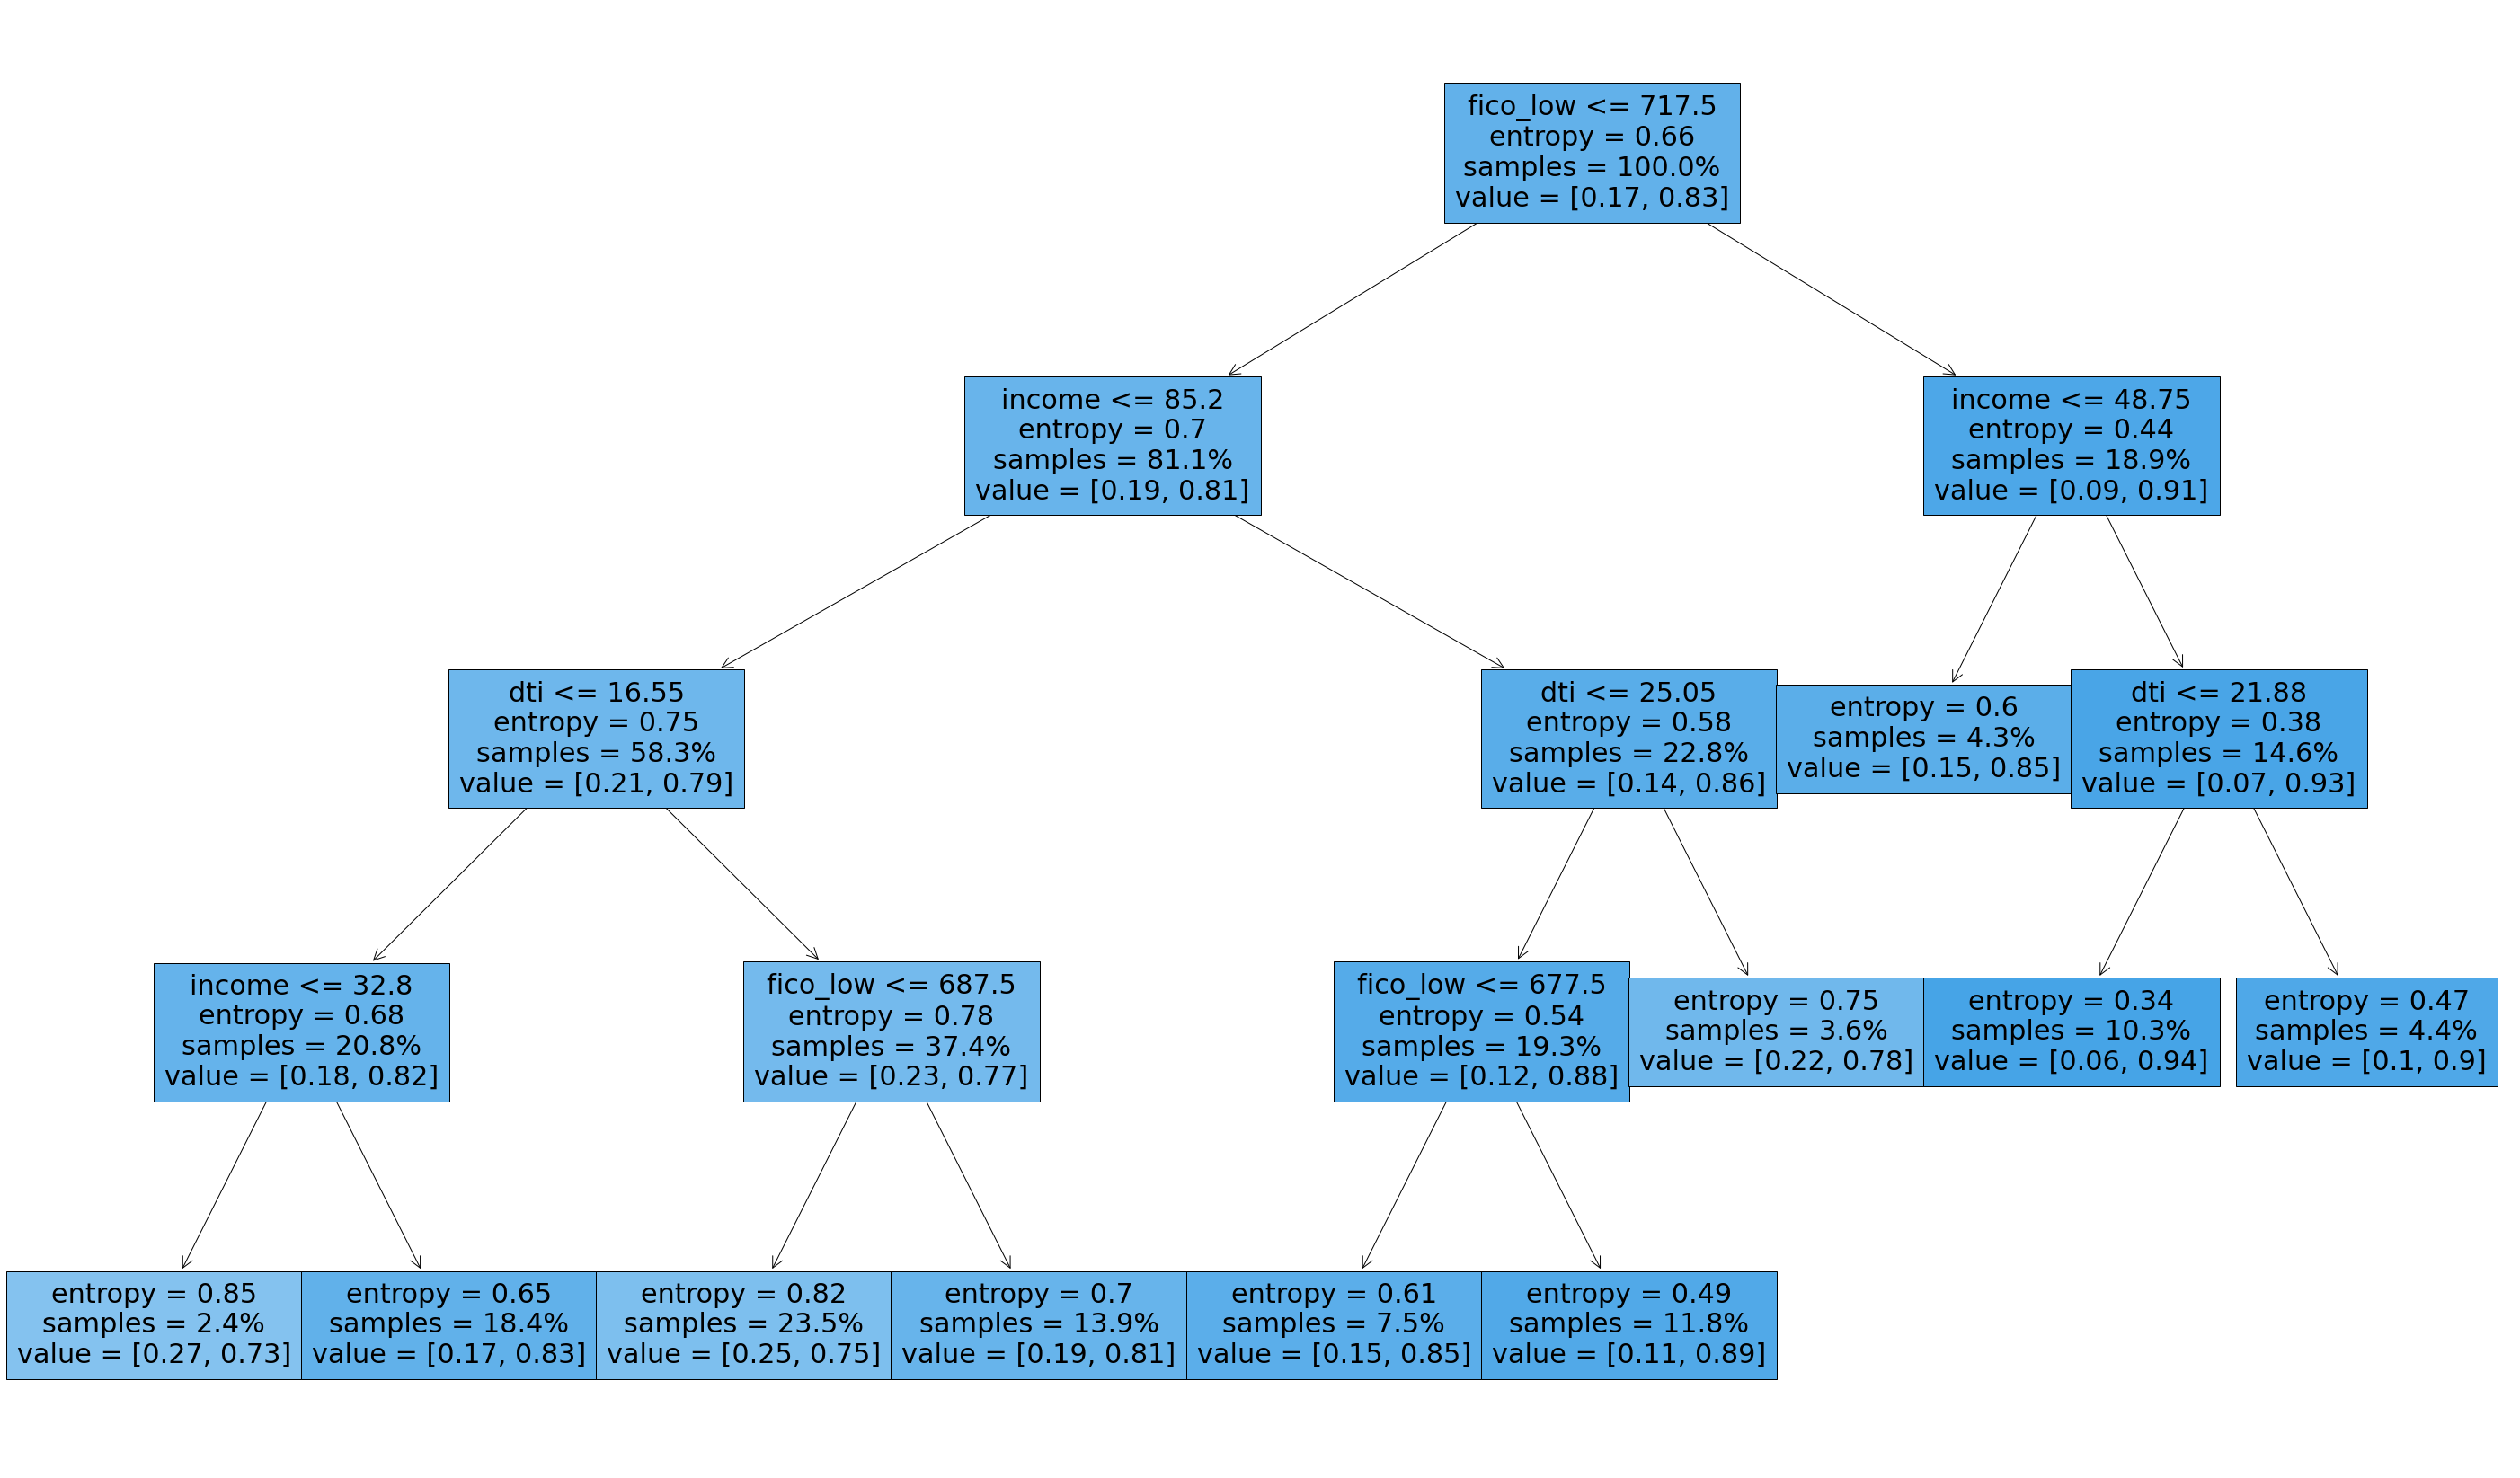

In [ ]:
clf = DecisionTreeClassifier(criterion='entropy',
                             max_depth=4,
                             min_samples_split=1000,
                             min_samples_leaf=200,
                             random_state=0)

X_train, y_train = lending_club_train_df.drop('loan_status', axis=1), lending_club_train_df['loan_status']
X_test, y_test = lending_club_test_df.drop('loan_status', axis=1), lending_club_test_df['loan_status']
print("label 比例:", round(y_train.sum()/len(y_train), 3), '\n')

clf.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(50, 30))
plot_tree(clf, filled=True, feature_names=X_train.columns, proportion=True, precision=2)
plt.show()

In [ ]:
0.811*0.7 + 0.189*0.44 # 比 initial 的 0.66 來得低一點

0.65086

In [ ]:
tp, fn, fp, tn = np.flip(confusion_matrix(y_true=y_train, y_pred=clf.predict_proba(X_train)[:, 1] > 0.9, normalize='all')).ravel()
np.array([[tp, fn], [fp, tn]])

array([[0.09614721, 0.73145486],
       [0.00655549, 0.16584244]])

In [ ]:
round(roc_auc_score(y_true=y_test, y_score=clf.predict_proba(X_test)[:, 1]), 3)

0.595

* continuous target value
    * minimize expected mse

In [ ]:
iowa_original_df = DataLoader.load_data('iowa_original')
target = iowa_original_df['SalePrice']
iowa_df_with_numerical = iowa_original_df[[col for col in iowa_original_df.columns 
                                               if (iowa_original_df[col].dtype == int)]].drop('SalePrice', axis=1)                   

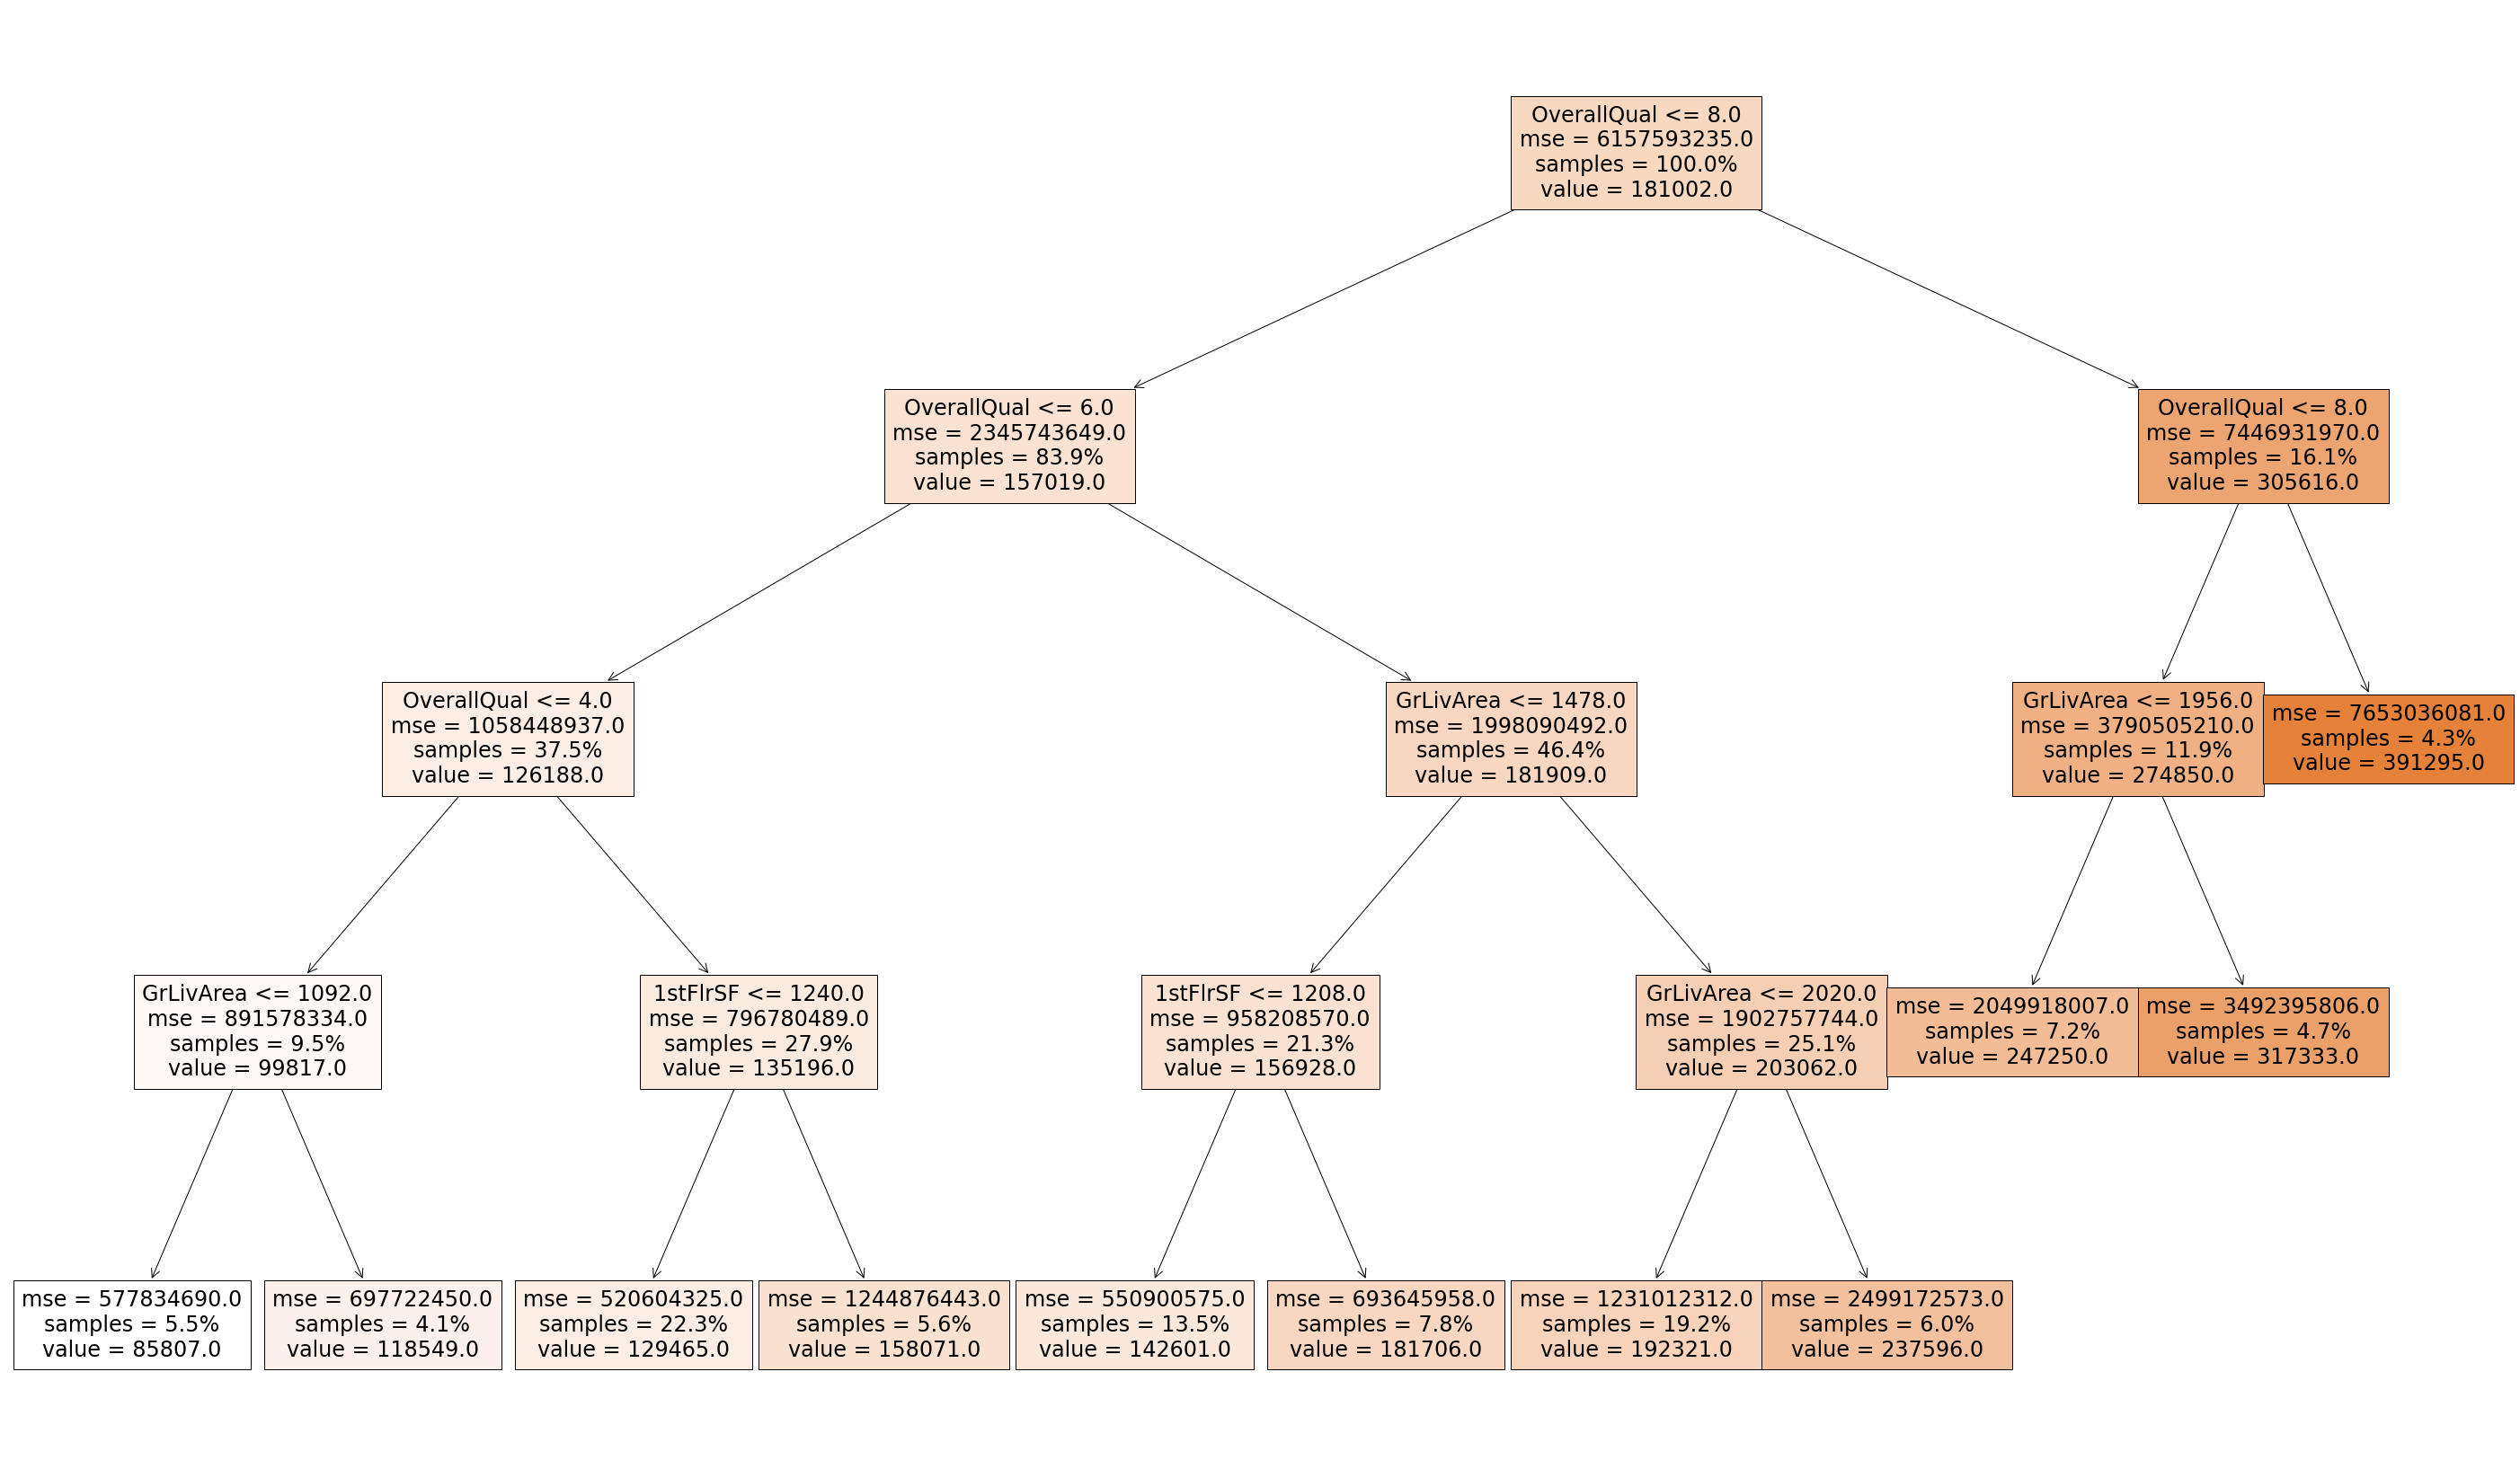

In [ ]:
clf = DecisionTreeRegressor(max_depth=4, min_samples_split=200)

X, y = iowa_df_with_numerical, target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(50, 30))
plot_tree(clf, filled=True, feature_names=X_train.columns, proportion=True, precision=0)
plt.show()

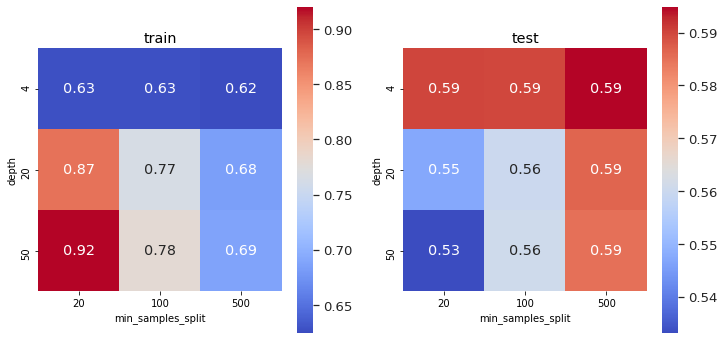

In [ ]:
#@title depth / min_samples_split
def heatmap(data, ax=None, title=""):
    sns.set(font_scale=1.2)
    hm = sns.heatmap(data,
                     cmap='coolwarm',
                     annot=True,
                     square=True,
                     fmt='.2f',
                     ax=ax,
                     yticklabels=data.index,
                     xticklabels=data.columns)
    ax.set_title(title)
    ax.set_ylabel('depth')
    ax.set_xlabel('min_samples_split')

X_train, y_train = lending_club_train_df.drop('loan_status', axis=1), lending_club_train_df['loan_status']
X_test, y_test = lending_club_test_df.drop('loan_status', axis=1), lending_club_test_df['loan_status']

train_auc = pd.DataFrame()
test_auc = pd.DataFrame()

for depth, min_samples_split in itertools.product([4, 20, 50], [20, 100, 500]):
    clf = DecisionTreeClassifier(criterion='entropy',
                                 max_depth=depth, 
                                 min_samples_split=min_samples_split)
    clf.fit(X_train, y_train)
    auc_train = round(roc_auc_score(y_true=y_train, y_score=clf.predict_proba(X_train)[:, 1]), 4)
    auc_test = round(roc_auc_score(y_true=y_test, y_score=clf.predict_proba(X_test)[:, 1]), 4)
    train_auc.loc[depth, min_samples_split] = auc_train
    test_auc.loc[depth, min_samples_split] = auc_test

fig, axes = plt.subplots(1, 2, figsize=(12,6))
heatmap(train_auc, ax=axes[0], title='train')
heatmap(test_auc, ax=axes[1], title='test')
plt.show()

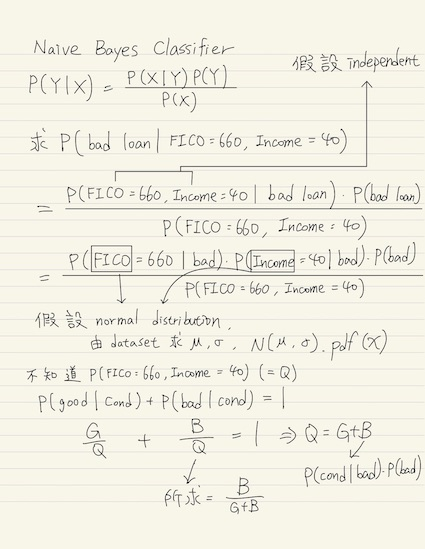

In [ ]:
col = ['fico_low', 'income']
X_good = lending_club_train_df[lending_club_train_df['loan_status'] == 1][col]
X_bad = lending_club_train_df[lending_club_train_df['loan_status'] == 0][col]
good_ms, bad_ms = StandardScaler().fit(X_good), StandardScaler().fit(X_bad)

ms_df = pd.DataFrame(np.array([np.vstack([ms.mean_, ms.scale_]).ravel('F') for ms in [good_ms, bad_ms]]),
                     columns=['Mean FICO', 'SD FICO', 'Mean Income', 'SD Income'],
                     index=['good', 'bad']).round(2)
ms_df

,Mean FICO,SD FICO,Mean Income,SD Income
good,696.19,31.28,79.83,59.24
bad,686.65,24.17,68.47,48.79


In [ ]:
P_660_given_bad = norm(loc=ms_df.loc['bad', 'Mean FICO'], scale=ms_df.loc['bad', 'SD FICO']).pdf(660)
P_40_given_bad = norm(loc=ms_df.loc['bad', 'Mean Income'], scale=ms_df.loc['bad', 'SD Income']).pdf(40)
P_660_given_good = norm(loc=ms_df.loc['good', 'Mean FICO'], scale=ms_df.loc['good', 'SD FICO']).pdf(660)
P_40_given_good = norm(loc=ms_df.loc['good', 'Mean Income'], scale=ms_df.loc['good', 'SD Income']).pdf(40)
P_bad = len(X_bad)/len(lending_club_train_df)
P_good = 1-P_bad

In [ ]:
B = P_660_given_bad * P_40_given_bad * P_bad
G = P_660_given_good * P_40_given_good * P_good
Q = B+G     # B/Q + G/Q = P_good_given_660_40 + P_bad_given_660_40 = 1

P_bad_given_660_40 = B/Q
round(P_bad_given_660_40, 3)

0.269

In [ ]:
GaussianNB().fit(lending_club_train_df[col],
                 lending_club_train_df['loan_status'])\
            .predict_proba(np.array([[660, 40]])).round(3)

array([[0.269, 0.731]])

In [ ]:
X, y = iowa_df_with_numerical, target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Ensemble Learning

Random Forest

In [ ]:
from multiprocessing import Pool
import time

def proc_needs_5sec():
    np.random.seed()
    time.sleep(5)
    return "OK"

pool = Pool(2)
result1 = pool.apply_async(proc_needs_5sec)
result2 = pool.apply_async(proc_needs_5sec)

s = time.time()
res1 = result1.get(timeout=10)
res2 = result2.get(timeout=10)
print(time.time()-s)
print("proc1: ", res1)
print("proc2: ", res2)

5.002973794937134
proc1:  OK
proc2:  OK


In [ ]:
bootstrapped_idx = np.random.choice(X_train.index, size=len(X_train))
bootstrapped_dataset = X_train.loc[bootstrapped_idx]
bootstrapped_dataset.loc[bootstrapped_dataset[bootstrapped_dataset.duplicated()].index[0]]

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
2501,2510,20,8760,8,5,2006,2006,36,0,1453,1489,1500,0,0,1500,2,0,3,1,7,1,2,674,144,38,0,0,0,0,0,6,2007
2501,2510,20,8760,8,5,2006,2006,36,0,1453,1489,1500,0,0,1500,2,0,3,1,7,1,2,674,144,38,0,0,0,0,0,6,2007


In [ ]:
def grow_a_tree():
    np.random.seed()
    reg = DecisionTreeRegressor(max_depth=6, max_features='sqrt')
    bootstrapped_idx = np.random.choice(X_train.index, size=len(X_train))
    reg.fit(X_train.loc[bootstrapped_idx], y_train.loc[bootstrapped_idx])
    
    return reg

def predict(reg):
    return reg.predict(X_test)

for n_estimators in [1, 10, 100]:
    pool = Pool(n_estimators)
    jobs = [pool.apply_async(grow_a_tree) for _ in range(n_estimators)]
    estimators = [job.get() for job in jobs]
    predictions = np.array(pool.map(predict, estimators)).mean(axis=0)
    print("n_estimators: {:3},  test error: {}, r_squared: {}".format(n_estimators,
                                                       round(mean_squared_error(predictions, y_test), 0),
                                                       round(r2_score(predictions, y_test), 3)))
pool.close()

n_estimators:   1,  test error: 1640793584.0, r_squared: 0.67
n_estimators:  10,  test error: 787671585.0, r_squared: 0.812
n_estimators: 100,  test error: 672758903.0, r_squared: 0.842


#### AdaBoost
$f_1(x)$ classifier 的 error rate < 0.5 <br>
調整每筆data的權重 分錯就 $*d_1$, 分對則 $/d_1$, $d_1 > 1$ <br>
可以推得若設 $d_t = \sqrt{(1-\epsilon_t)/\epsilon_t}, (d_t > 1$  因為 $\epsilon_t < 0.5)$ <br>
新的 error rate 可以使得 $f_1$ 的 error rate 為 0.5 <br>
令 $\alpha_t = ln(d_t)$ <br>
$u_{t+1}^n ← u_t^n exp(-sign(y^n f_t(x^n))\alpha_t)$ <br>
以此新的 dataset train 出 $f_2$<br>
最後的 prediction $= H(x) = sign(\alpha_t f_t(x))$ <br>
可以證明隨著 t 越大, H(x) 的 error rate 必越小

In [ ]:
clf = DecisionTreeClassifier(criterion='entropy',
                             max_depth=1,
                             random_state=0)
base_estimator = DecisionTreeClassifier(criterion='entropy',
                                        max_depth=1,
                                        random_state=0)
ada_clf = AdaBoostClassifier(base_estimator, n_estimators=100)

X_train, y_train = lending_club_train_df.drop('loan_status', axis=1), lending_club_train_df['loan_status']
X_test, y_test = lending_club_test_df.drop('loan_status', axis=1), lending_club_test_df['loan_status']

clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

print("clf train auc: ", round(roc_auc_score(y_true=y_train, y_score=clf.predict_proba(X_train)[:, 1]), 3))
print("clf test auc: ", round(roc_auc_score(y_true=y_test, y_score=clf.predict_proba(X_test)[:, 1]), 3))

print("ada_clf train auc: ", round(roc_auc_score(y_true=y_train, y_score=ada_clf.predict_proba(X_train)[:, 1]), 3))
print("ada_clf test auc: ", round(roc_auc_score(y_true=y_test, y_score=ada_clf.predict_proba(X_test)[:, 1]), 3))

clf train auc:  0.554
clf test auc:  0.548
ada_clf train auc:  0.65
ada_clf test auc:  0.608


#### Gradient Boosting
以下以 continuous value prediction 作為例子 <br>
idea: 一個複雜的預測模型可能是由多個相對簡單的模型構成的 <br>
$f(x) = w_0 + \sum_{m=1}^M w_m \phi_m(x)$ <br>
$w_0 = f_0(x) = argmin_{\gamma} \sum_{i=1}^N L(y_i, \phi(x|\gamma)) => \phi(x|\gamma) = \bar{y}$: 最粗略的預測，一個數做所有預測 <br>
for m in 1~M:
>計算 $r_{im} = -[\frac{\partial L(y_i, F(x_i))}{\partial{F(x_i)}}]_{F(x_i)=f_{m-1}(x_i)}$ <br>
>$L(y_i, F(x_i)) = \frac{1}{2}(y_i - F(x_i))^2, r_{im} = (y_i - f_{m-1}(x_i)) = (label_i - prediction_i) = residual_i$ <br>
>若要使得Loss更低，把$f_{m-1}$加上gradient的反向，也就是residual <br>
>問題是，我們應該要加上一個 predict function 才合理，而不是一些定值

>使用 weak learner $\phi$ 去 fit residual, 求 $\gamma_m = argmin_{\gamma_{m}} \sum_{i=1}^N (r_{im} - \phi(x_i|\gamma_m))^2$ <br>
>以 DecisionTreeRegressor 來說，會去 fit 那些 residual，output葉節點的平均值 => 使上式最小

>$f_m ← f_{m-1} + \nu \phi(x|\gamma_m), \nu$ is learning rate, often set to 0.1

return $f(x) = f_M(x)$

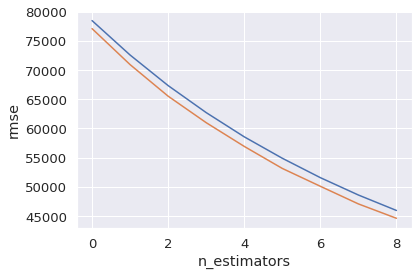

In [ ]:
X, y = iowa_df_with_numerical, target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clfs, train_rmse_records, test_rmse_records = [], [], []
previous_pred = w0 = y_train.mean()
for m in range(1, 10):
    train_rmse = np.sqrt(((y_train - previous_pred)**2).mean())
    test_prediction = w0 + np.array([0.1 * clf.predict(X_test) for clf in clfs]).sum(0).ravel()
    test_rmse = np.sqrt(((y_test - test_prediction)**2).mean())
    # print("{}th predictor, train_rmse: {:.2E}, test_rmse: {:.2E}".format(m-1, train_rmse, test_rmse))
    
    train_rmse_records.append(train_rmse)
    test_rmse_records.append(test_rmse)

    residual = y_train - previous_pred
    clf = DecisionTreeRegressor(max_leaf_nodes=8)
    clf.fit(X_train, residual)
    clfs.append(clf)
    previous_pred = previous_pred + 0.1 * clf.predict(X_train)
plt.xlabel('n_estimators')
plt.ylabel('rmse')
plt.plot(train_rmse_records)
plt.plot(test_rmse_records)
plt.show()

In [ ]:
full_df = DataLoader.load_data('lending_club_full_url')
full_df = full_df[full_df.columns[1:]]

In [ ]:
df = full_df[['home_ownership', 'annual_inc', 'dti', 'fico_range_low', 'loan_status', 'last_fico_range_low']]
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off']).values]
df = df[df['home_ownership'].isin(['OWN', 'RENT']).values]
df['loan_status'] = df['loan_status'].replace({"Charged Off": 0, "Fully Paid": 1})
df['home_ownership'] = df['home_ownership'].replace({"RENT": 0, "OWN": 1})
df['annual_inc'] /= 1e3

In [ ]:
params = {
    "strong_model": {
        "max_depth": 30,
        "min_samples_split": 30,
        "random_state": 0
    },
    "weak_model": {
        "max_depth": 2,
        "min_samples_split": 500,
        "random_state": 0
    }
}

X = df.drop('loan_status', axis=1)
y = df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

In [ ]:
def compare_models(algos: list, strength: str):
    print(strength, 'classifier \n')
    pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('classifier', 'passthrough')])
    for algo in algos:
        pipe.set_params(classifier=algo(**params[strength + '_model']))
        _ = pipe.fit(X_train, y_train)
        print("algo :", algo.__name__)
        print(round(roc_auc_score(y_train, pipe.predict_proba(X_train)[:, 1]), 3))
        print(round(roc_auc_score(y_test, pipe.predict_proba(X_test)[:, 1]), 3), '\n')

In [ ]:
compare_models([DecisionTreeClassifier,
                RandomForestClassifier,
                GradientBoostingClassifier],
                'strong')

strong classifier 

algo : DecisionTreeClassifier
0.978
0.911 

algo : RandomForestClassifier
0.978
0.95 

algo : GradientBoostingClassifier
1.0
0.942 



In [ ]:
compare_models([DecisionTreeClassifier,
                RandomForestClassifier,
                GradientBoostingClassifier],
                'weak')

weak classifier 

algo : DecisionTreeClassifier
0.929
0.933 

algo : RandomForestClassifier
0.937
0.938 

algo : GradientBoostingClassifier
0.956
0.949 



In [ ]:
df_with_float_col = full_df[[col for col in full_df.columns 
                                  if (full_df[col].dtype == float) and (col not in df.columns)]]
df_with_float_col = df_with_float_col.loc[df.index, :]
df_with_float_col = df_with_float_col.dropna(axis=1,
                                                       thresh=int(len(df_with_float_col))*0.95)

orig_addi_df = pd.concat([df, df_with_float_col], axis=1)
orig_features = list(df.drop('loan_status', axis=1).columns)
addi_features = list(df_with_float_col.columns)

In [ ]:
orig_features_transformer = SimpleImputer(strategy='median')
addi_features_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                                      ('feature_selection', SelectKBest(chi2, k=2))])

preprocessor = ColumnTransformer(transformers=[('orig', orig_features_transformer, orig_features),
                                               ('addi', addi_features_transformer, addi_features)])

In [ ]:
clf = DecisionTreeClassifier(criterion='entropy',
                             max_depth=10,
                             min_samples_split=500,
                             random_state=0)

pipe = Pipeline([('preprocessor', preprocessor),
                 ('classifier', clf)])

X = orig_addi_df.drop('loan_status', axis=1)
y = orig_addi_df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('orig',
                                                  SimpleImputer(strategy='median'),
                                                  ['home_ownership',
                                                   'annual_inc', 'dti',
                                                   'fico_range_low',
                                                   'last_fico_range_low']),
                                                 ('addi',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('feature_selection',
                                                                   SelectKBest(k=2,
                                                                               score_func=<function chi2 at 0x7f9a203bd830>))]),
                                                  ['loan_amnt', 'i...
                                                   'fico_range_high',
                                                   'inq_last_6mths', 'open_acc',
                                                   'pub_rec', 'revol_bal',
                                                   'revol_util', 'total_acc',
                                                   'last_fico_range_high',
                                                   'collections_12_mths_ex_med',
                                                   'policy_code',
                                                   'acc_now_delinq',
                                                   'chargeoff_within_12_mths',
                                                   'delinq_amnt',
                                                   'pub_rec_bankruptcies',
                                                   'tax_liens'])])),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=10,
                                        min_samples_split=500,
                                        random_state=0))])

In [ ]:
feature_selected_idx = pipe.named_steps['preprocessor'].named_transformers_['addi'].named_steps['feature_selection'].get_support(True)
selected_features = list(np.array(addi_features)[feature_selected_idx])
selected_features

['loan_amnt', 'delinq_amnt']

In [ ]:
print(round(roc_auc_score(y_train, pipe.predict_proba(X_train)[:, 1]), 4))
print(round(roc_auc_score(y_test, pipe.predict_proba(X_test)[:, 1]), 4))

0.9507
0.9392
